# Prediction of Covid-19 from Chest X-Ray Images Using Deep Learning Algorithms(CNN)

### 1. Literature Review on Technical Challenges in Covid-19 Prediction Using Chest X-Ray Images with Deep Learning CNN Models

##### Introduction

The global Covid-19 pandemic has necessitated rapid and accurate diagnostic methods. Chest X-ray (CXR) imaging, combined with deep learning models like Convolutional Neural Networks (CNNs), has shown promise in predicting Covid-19 infection. However, several technical challenges need to be addressed to enhance the accuracy and reliability of these models. This literature review identifies and discusses these challenges.

#### Data Quality and Quantity
The availability of high-quality, labeled CXR images for Covid-19 is limited, leading to small, imbalanced datasets that can cause overfitting. Accurate annotation by expert radiologists is time-consuming and expensive, resulting in inconsistent training data.

#### Image Preprocessing
CXR images vary in quality, resolution, and noise due to different sources, necessitating standardized preprocessing. Data augmentation is essential to increase dataset size but must be designed carefully to avoid introducing artifacts.

#### Model Architecture and Training
Designing CNNs that are both deep enough to capture complex patterns and efficient enough to avoid overfitting is challenging. Transfer learning can help, but adapting pre-trained models to CXR images for Covid-19 prediction poses domain adaptation issues.

#### Evaluation and Validation
Common metrics need to be supplemented with metrics like AUC-ROC to handle imbalanced datasets. Cross-dataset validation ensures models generalize across different clinical settings 


###### The main purpose of this project is to build a CNN model that would classify if subject has a Covid or not base on Chest X-Ray images. I used the VGG-16 model architecture and weights to train the model for this binary problem. I used accuracy as a metric to justify the model performance which can be defined as:

Accuracy = Number of correclty predicted images / Total number of tested images *100%

validation set - is the set used during the model training to adjust the hyperparameters.

test set - is the small set that I don't touch for the whole training process at all. It's been used for final model performance evaluation.



### 2. Data Set

#### 2.1 Loading the Dataset

In [189]:
# Installing a package to download data from Kaggle
!pip install -q opendatasets

In [190]:
import opendatasets as od
import pandas as pd

In [191]:
od.download('https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset/data', force = True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mayankkatkoriya
Your Kaggle Key: ········
Dataset URL: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset


100%|████████████████████████████████████████| 158M/158M [00:08<00:00, 20.5MB/s]


#### 2.2 PyTorch Dataset and Dataloader

In [192]:
!pip install torch torchvision

In [193]:
# Import necessary packages.
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# This is for the progress bar
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

The train_transform defined below is a series of image preprocessing steps for training data in PyTorch. It includes random cropping and resizing to 224x224, random horizontal flipping, conversion to a tensor, and normalization using specified mean and standard deviation values to standardize the image pixel values.

In [194]:
# Define transform for training data
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224), #Randomly crop the image and resize it to height x width = (224x224)
    torchvision.transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
    torchvision.transforms.ToTensor(),             # Convert the image to tensor
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize the image
])

In [195]:
# Define transform for testing and/validation data
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),     # Resize the image to 256x256
    torchvision.transforms.CenterCrop(224), # Crop the center of the image to 224x224
    torchvision.transforms.ToTensor(),      # Convert the image to tensor
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224,0.225]) # Normalize the image
])

In [196]:
#Now we will create the Datasets

The train_dataset and test_dataset are created using the ImageFolder dataset class from PyTorch's torchvision.datasets module.

train_dataset loads images from the directory "covid19-image-dataset/Covid19-dataset/train/" and applies the train_transform preprocessing steps.
test_dataset loads images from the directory "covid19-image-dataset/Covid19-dataset/test/" and applies the test_transform preprocessing steps.

In [197]:
train_dataset = datasets.ImageFolder("covid19-image-dataset/Covid19-dataset/train/", transform=train_transform)
test_dataset = datasets.ImageFolder("covid19-image-dataset/Covid19-dataset/test/", transform=test_transform)

The train_ratio and val_ratio variables below define the proportion of data allocated for training and validation, respectively. For instance, with train_ratio = 0.9 and val_ratio = 0.1, 90% of the dataset is used for training and 10% for evaluation, ensuring balanced data splitting.

In [198]:
# Define the desired ratio for train and evaluation data (e.g., 90% train, 10% evaluation)
train_ratio = 0.9
val_ratio = 1 - train_ratio

In [199]:
# calulating the sizes of train and evaluation datasets based on the ratios
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

The code below splits train_dataset into train_subset and val_subset using the random_split function. The sizes for each subset are specified by train_size and val_size, ensuring the dataset is divided into training and validation parts according to the defined ratio.

In [200]:
# Split the train dataset into train and evaluation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [201]:
print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 251 samples
Train set has 225 samples
Validation set has 26 samples
Test set has 66 samples


The batch_size variable below is set to 32, which defines the number of samples processed together in one iteration during training, validation, and testing.

In [202]:
 # now we will define batch size for training, validation, and testing
 batch_size = 32

In [203]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader =  DataLoader(val_subset,batch_size=batch_size,shuffle=True)

In [221]:
#show some sample images
def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        index = np.random.randint(len(dataset))
        image, label = dataset[index]
        axes[i].imshow(image.permute(1, 2, 0))  # Convert tensor to numpy array and permute dimensions
        axes[i].set_title('Label: {}'.format(dataset.classes[label]))
        axes[i].axis('off')
        plt.show()

Now we will load a batch of 5 images from the training subset using DataLoader. It then creates a grid of these images with torchvision.utils.make_grid and visualizes them using imshow. The images are labeled with class names: 'Normal', 'Covid', and 'Viral-Pneumonia'.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


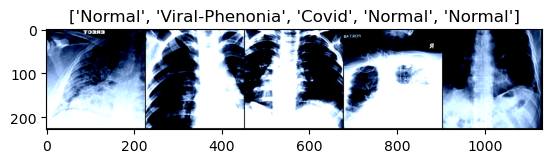

In [222]:
# Get a batch of training data
train_loader_for_vis = DataLoader(train_subset, batch_size=5, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['Normal', 'Covid', 'Viral-Phenonia']

imshow(out, title=[class_names[x] for x in classes])

In [209]:
# get a batch of training data
images, labels = get_batch(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


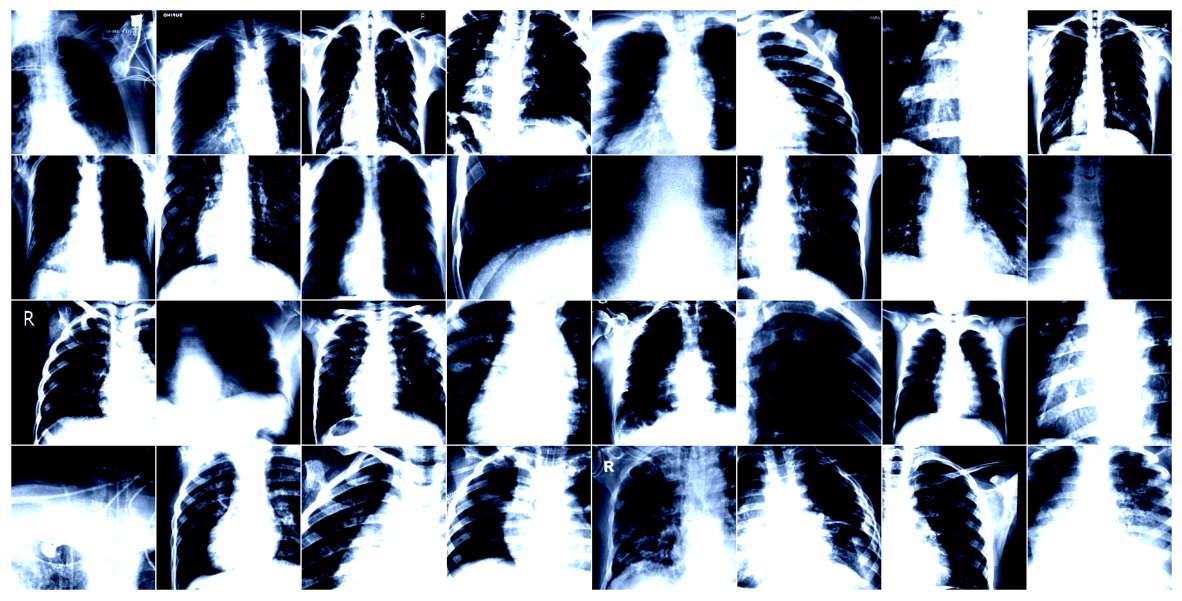

In [210]:
# make a grid from the batch of images
make_grid(images)

### 3. Model

The code below defines a CNN model for image classification. It consists of convolutional layers followed by max-pooling for feature extraction and dimensionality reduction. ReLU activation functions introduce non-linearity. The convolutional layers apply filters to detect patterns in the input image, while max-pooling reduces spatial dimensions. The fully connected layers process flattened feature maps for classification. The model's architecture includes two convolutional blocks, each followed by max-pooling, and two fully connected layers. The final output layer produces predictions for the number of classes in the dataset. This architecture enables effective image classification tasks by learning hierarchical representations of input images.

In [211]:
# Define the CNN model
class CNN_Model(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Model, self).__init__()
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
           # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.conv_layers(x)
        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)
        # Forward pass through fully connected layers
        x = self.fc_layers(x)
        return x

        # Create an instance of the CNN model
num_classes = len(train_dataset.classes)
model = CNN_Model(num_classes)

# Print the model architecture
print(model)



CNN_Model(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=100352, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
)


In [212]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Define Loss and Optimizer

We use **CrossEntropyLoss** function to define the loss criterion. This loss function is commonly used for classification problems with multiple classes,which is suitable for brain tumour detection, where we have two classes.

In [213]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

We use the optim.Adam() optimizer to optimize the model parameters during training.

The lr = 0.003 argument sets the learning rate, which determines the step size that the optimizer takes during the optimization process.

In [214]:
# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

This code trains a CNN model over 100 epochs using training and validation datasets. For each epoch, it computes and records training and validation losses and accuracies. After each epoch, training and validation metrics are printed for monitoring model performance.

In [215]:
# The number of training epochs.
n_epochs = 100

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 001/100] Train: loss=1.32186, acc=0.45399 | Valid: loss=0.81868, acc=0.73077


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 002/100] Train: loss=0.97142, acc=0.53747 | Valid: loss=0.82524, acc=0.65385


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 003/100] Train: loss=0.89112, acc=0.62167 | Valid: loss=0.64938, acc=0.73077


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 004/100] Train: loss=0.87503, acc=0.57653 | Valid: loss=0.72821, acc=0.57692


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 005/100] Train: loss=0.75343, acc=0.68099 | Valid: loss=0.73138, acc=0.73077


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 006/100] Train: loss=0.72640, acc=0.67390 | Valid: loss=0.64222, acc=0.69231


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 007/100] Train: loss=0.61417, acc=0.75275 | Valid: loss=0.53665, acc=0.73077


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 008/100] Train: loss=0.60903, acc=0.73712 | Valid: loss=0.53579, acc=0.69231


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 009/100] Train: loss=0.61585, acc=0.76664 | Valid: loss=0.48255, acc=0.84615


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 010/100] Train: loss=0.54399, acc=0.79080 | Valid: loss=0.43980, acc=0.84615


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 011/100] Train: loss=0.50897, acc=0.77127 | Valid: loss=0.47852, acc=0.84615


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 012/100] Train: loss=0.53969, acc=0.78299 | Valid: loss=0.50089, acc=0.73077


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 013/100] Train: loss=0.55623, acc=0.78935 | Valid: loss=0.30778, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 014/100] Train: loss=0.61944, acc=0.70660 | Valid: loss=0.43826, acc=0.80769


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 015/100] Train: loss=0.57781, acc=0.74277 | Valid: loss=0.45204, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 016/100] Train: loss=0.49188, acc=0.80425 | Valid: loss=0.43416, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 017/100] Train: loss=0.53396, acc=0.80035 | Valid: loss=0.41469, acc=0.76923


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 018/100] Train: loss=0.55274, acc=0.78328 | Valid: loss=0.57510, acc=0.69231


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 019/100] Train: loss=0.45408, acc=0.81641 | Valid: loss=0.33993, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 020/100] Train: loss=0.52808, acc=0.77156 | Valid: loss=0.59505, acc=0.76923


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 021/100] Train: loss=0.46864, acc=0.83623 | Valid: loss=0.37331, acc=0.84615


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 022/100] Train: loss=0.46167, acc=0.79427 | Valid: loss=0.35884, acc=0.80769


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 023/100] Train: loss=0.47266, acc=0.83160 | Valid: loss=0.32470, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 024/100] Train: loss=0.48524, acc=0.81424 | Valid: loss=0.25368, acc=1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 025/100] Train: loss=0.42105, acc=0.82914 | Valid: loss=0.46099, acc=0.80769


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 026/100] Train: loss=0.46439, acc=0.79470 | Valid: loss=0.28024, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 027/100] Train: loss=0.41871, acc=0.84621 | Valid: loss=0.63960, acc=0.76923


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 028/100] Train: loss=0.41525, acc=0.82914 | Valid: loss=0.26336, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 029/100] Train: loss=0.40088, acc=0.84795 | Valid: loss=0.25418, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 030/100] Train: loss=0.42481, acc=0.83377 | Valid: loss=0.30108, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 031/100] Train: loss=0.49261, acc=0.78762 | Valid: loss=0.30742, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 032/100] Train: loss=0.47682, acc=0.82060 | Valid: loss=0.55828, acc=0.80769


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 033/100] Train: loss=0.49903, acc=0.79861 | Valid: loss=0.26405, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 034/100] Train: loss=0.42473, acc=0.84722 | Valid: loss=0.33251, acc=0.80769


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 035/100] Train: loss=0.44511, acc=0.82841 | Valid: loss=0.40151, acc=0.76923


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 036/100] Train: loss=0.47466, acc=0.78545 | Valid: loss=0.35898, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 037/100] Train: loss=0.44798, acc=0.82451 | Valid: loss=0.38309, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 038/100] Train: loss=0.47484, acc=0.78472 | Valid: loss=0.31207, acc=0.84615


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 039/100] Train: loss=0.34038, acc=0.88209 | Valid: loss=0.38288, acc=0.84615


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 040/100] Train: loss=0.41405, acc=0.84867 | Valid: loss=0.48430, acc=0.80769


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 041/100] Train: loss=0.40609, acc=0.81843 | Valid: loss=0.35353, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 042/100] Train: loss=0.37570, acc=0.87355 | Valid: loss=0.16632, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 043/100] Train: loss=0.43263, acc=0.82841 | Valid: loss=0.30073, acc=0.84615


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 044/100] Train: loss=0.39903, acc=0.84476 | Valid: loss=0.36288, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 045/100] Train: loss=0.36987, acc=0.85185 | Valid: loss=0.30734, acc=0.84615


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 046/100] Train: loss=0.48606, acc=0.81424 | Valid: loss=0.51538, acc=0.80769


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 047/100] Train: loss=0.45559, acc=0.79890 | Valid: loss=0.20471, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 048/100] Train: loss=0.40377, acc=0.84404 | Valid: loss=0.41014, acc=0.76923


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 049/100] Train: loss=0.35079, acc=0.85402 | Valid: loss=0.29583, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 050/100] Train: loss=0.47185, acc=0.81279 | Valid: loss=0.20551, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 051/100] Train: loss=0.38463, acc=0.85648 | Valid: loss=0.28236, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 052/100] Train: loss=0.39052, acc=0.86328 | Valid: loss=0.18718, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 053/100] Train: loss=0.42189, acc=0.82668 | Valid: loss=0.21271, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 054/100] Train: loss=0.40798, acc=0.82277 | Valid: loss=0.20204, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 055/100] Train: loss=0.34828, acc=0.85966 | Valid: loss=0.35240, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 056/100] Train: loss=0.33818, acc=0.86429 | Valid: loss=0.44084, acc=0.80769


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 057/100] Train: loss=0.32613, acc=0.87746 | Valid: loss=0.32533, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 058/100] Train: loss=0.30886, acc=0.88701 | Valid: loss=0.23832, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 059/100] Train: loss=0.38296, acc=0.84722 | Valid: loss=0.24180, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 060/100] Train: loss=0.31788, acc=0.87674 | Valid: loss=0.23780, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 061/100] Train: loss=0.43854, acc=0.82060 | Valid: loss=0.29137, acc=0.84615


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 062/100] Train: loss=0.32847, acc=0.86502 | Valid: loss=0.18689, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 063/100] Train: loss=0.35302, acc=0.87674 | Valid: loss=0.26238, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 064/100] Train: loss=0.35094, acc=0.87601 | Valid: loss=0.12793, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 065/100] Train: loss=0.34348, acc=0.87746 | Valid: loss=0.22754, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 066/100] Train: loss=0.33165, acc=0.88845 | Valid: loss=0.15163, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 067/100] Train: loss=0.39123, acc=0.85330 | Valid: loss=0.22385, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 068/100] Train: loss=0.32732, acc=0.85894 | Valid: loss=0.44559, acc=0.80769


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 069/100] Train: loss=0.40921, acc=0.82841 | Valid: loss=0.23509, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 070/100] Train: loss=0.37150, acc=0.84939 | Valid: loss=0.30480, acc=0.84615


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 071/100] Train: loss=0.36074, acc=0.84621 | Valid: loss=0.33260, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 072/100] Train: loss=0.36934, acc=0.86892 | Valid: loss=0.19953, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 073/100] Train: loss=0.31012, acc=0.89164 | Valid: loss=0.53942, acc=0.80769


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 074/100] Train: loss=0.33817, acc=0.87500 | Valid: loss=0.32264, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 075/100] Train: loss=0.36604, acc=0.82914 | Valid: loss=0.16116, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 076/100] Train: loss=0.37960, acc=0.87283 | Valid: loss=0.19145, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 077/100] Train: loss=0.33724, acc=0.86111 | Valid: loss=0.31466, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 078/100] Train: loss=0.34054, acc=0.85475 | Valid: loss=0.23327, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 079/100] Train: loss=0.40349, acc=0.84939 | Valid: loss=0.25470, acc=0.84615


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 080/100] Train: loss=0.29222, acc=0.88527 | Valid: loss=0.27176, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 081/100] Train: loss=0.42980, acc=0.82769 | Valid: loss=0.28725, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 082/100] Train: loss=0.32673, acc=0.85966 | Valid: loss=0.30235, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 083/100] Train: loss=0.27665, acc=0.90090 | Valid: loss=0.22541, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 084/100] Train: loss=0.34975, acc=0.85720 | Valid: loss=0.17630, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 085/100] Train: loss=0.33843, acc=0.87355 | Valid: loss=0.26670, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 086/100] Train: loss=0.30215, acc=0.87211 | Valid: loss=0.32142, acc=0.84615


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 087/100] Train: loss=0.35176, acc=0.84621 | Valid: loss=0.26866, acc=0.84615


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 088/100] Train: loss=0.33454, acc=0.87529 | Valid: loss=0.19841, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 089/100] Train: loss=0.35795, acc=0.85966 | Valid: loss=0.50462, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 090/100] Train: loss=0.32617, acc=0.88845 | Valid: loss=0.27879, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 091/100] Train: loss=0.33805, acc=0.86502 | Valid: loss=0.31506, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 092/100] Train: loss=0.33615, acc=0.85330 | Valid: loss=0.46520, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 093/100] Train: loss=0.32004, acc=0.86256 | Valid: loss=0.33602, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 094/100] Train: loss=0.34380, acc=0.86820 | Valid: loss=0.25217, acc=0.92308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 095/100] Train: loss=0.31063, acc=0.91045 | Valid: loss=0.66858, acc=0.80769


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 096/100] Train: loss=0.35262, acc=0.88166 | Valid: loss=0.18618, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 097/100] Train: loss=0.25779, acc=0.91826 | Valid: loss=0.29943, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 098/100] Train: loss=0.31797, acc=0.88383 | Valid: loss=0.20633, acc=0.96154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 099/100] Train: loss=0.31617, acc=0.86357 | Valid: loss=0.24411, acc=0.88462


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch: 100/100] Train: loss=0.32908, acc=0.85749 | Valid: loss=0.30778, acc=0.88462


Below, plots visualize the training and validation loss, as well as the training and validation accuracy, over the course of training epochs. 

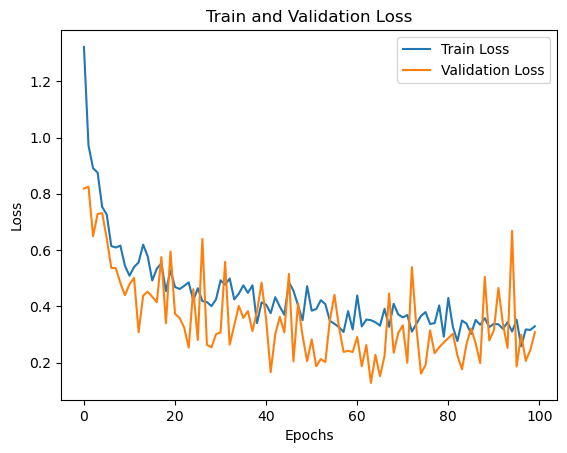

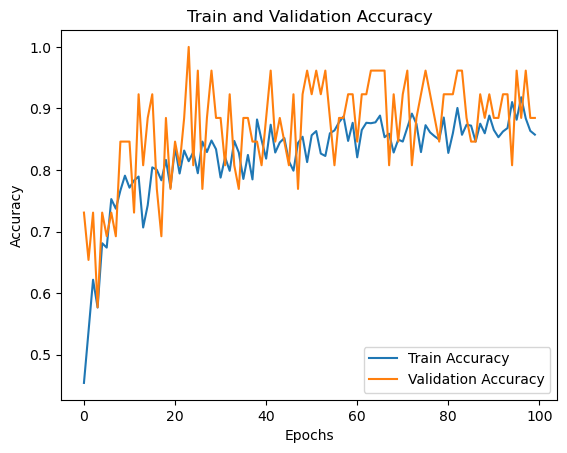

In [216]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

For the Training and Validation Loss both the training loss and validation loss curves converge over the epochs, indicating the model's progressive learning and performance improvement throughout the training process. 

The blue curve represents the training accuracy on the plot to the right, which starts low but increases steadily as the number of epochs increases. This indicates that the model is effectively learning and improving its performance on the training data. The orange curve represents the validation accuracy, which also shows an increasing trend. Despite some fluctuations, the overall validation accuracy stabilises at a high level. 

### Testing

Now, we will train a CNN model over 100 epochs using training and validation datasets. For each epoch, it computes and records training and validation losses and accuracies.

In [217]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/3 [00:00<?, ?it/s]

Test accuracy 0.8854166865348816


Now, we will evaluate the trained model on the test dataset

In [218]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(target.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

The code above evaluates the trained model on the test dataset. It sets the model to evaluation mode (model.eval()) to disable dropout and batch normalization layers. Then, we iterates through the test loader, computes predictions using the model, and collects them along with the true labels. Finally, converting the predictions and labels into numpy arrays for further analysis.

In [219]:
from sklearn.metrics import confusion_matrix

Below we calculate the confusion matrix based on the predicted labels (all_preds) and true labels (all_labels). The confusion matrix provides a summary of the model's performance by showing the number of true positives, true negatives, false positives, and false negatives for each class.

In [220]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
print(conf_matrix)

[[26  0  0]
 [ 1 11  8]
 [ 1  1 18]]


The confusion matrix shows the following:

Class 0 (Normal): 26 instances correctly classified as Normal.

Class 1 (Covid): 11 instances correctly classified as Covid, 1 instance misclassified as Normal, and 8 instances misclassified as Viral Pneumonia.

Class 2 (Viral Pneumonia): 18 instances correctly classified as Viral Pneumonia, 1 instance misclassified as Covid, and 1 instance misclassified as Normal.

The model successfully classifies chest X-ray images into three categories: viral pneumonia, covid pneumonia, and normal pneumonia. It obtains an accuracy of 88.54% on the test dataset. Although it is efficient in diagnosing instances, the confusion matrix shows that it is not always able to differentiate between cases of Covid and viral pneumonia.